# First Submission: Exploratory Data Analysis and Initial Feature Engineering

This notebook performs exploratory data analysis on the music streaming churn dataset and creates initial features for churn prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
train = pd.read_parquet('train.parquet', engine="fastparquet")
test = pd.read_parquet('test.parquet', engine="fastparquet")


print(f"\n Train shape: {train.shape}")
print(f" Test shape: {test.shape}")



 Train shape: (17499636, 19)
 Test shape: (4393179, 19)


In [3]:
train.sample(5)


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
11638281,200,F,Melissa,paid,Williams,1043525,1541388635000,Logged In,NextSong,156517,"Washington-Arlington-Alexandria, DC-VA-MD-WV",240,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",PUT,290.29832,We Can Smoke,Big Tymers / TQ,2018-11-05 03:30:35,2018-07-12 00:22:29
7533485,200,M,Thomas,paid,White,1885160,1540323489000,Logged In,Add to Playlist,114768,"Providence-Warwick, RI-MA",82,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",PUT,NaN,None,None,2018-10-23 19:38:09,2018-09-06 21:45:48
24009939,200,M,Sebastian,free,Gallegos,1312860,1540066080000,Logged In,Roll Advert,13395,"Atlanta-Sandy Springs-Roswell, GA",12,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,GET,NaN,None,None,2018-10-20 20:08:00,2018-08-27 13:36:04
24956351,200,M,Donovan,paid,Roach,1201224,1541571230000,Logged In,NextSong,27328,"Dayton, OH",26,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,PUT,251.55873,Without Me,Eminem,2018-11-07 06:13:50,2018-08-28 00:56:29
24712360,200,F,Aleenah,paid,Gay,1096280,1541149620000,Logged In,NextSong,26016,"Miami-Fort Lauderdale-West Palm Beach, FL",106,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,180.42730,Slack Jaw,The Bluetones,2018-11-02 09:07:00,2018-09-23 00:19:24


In [4]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 17499636 entries, 0 to 25661583
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   status         int64         
 1   gender         object        
 2   firstName      object        
 3   level          object        
 4   lastName       object        
 5   userId         object        
 6   ts             int64         
 7   auth           object        
 8   page           object        
 9   sessionId      int64         
 10  location       object        
 11  itemInSession  int64         
 12  userAgent      object        
 13  method         object        
 14  length         float64       
 15  song           object        
 16  artist         object        
 17  time           datetime64[ns]
 18  registration   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(12)
memory usage: 2.6+ GB


In [5]:
train.isna().sum()[train.isna().sum() > 0]


length    3208203
song      3208203
artist    3208203
dtype: int64

In [6]:
user_churn = train.groupby('userId')['page'].apply(
    lambda x: 1 if 'Cancellation Confirmation' in x.values else 0
).reset_index()
user_churn.columns = ['userId', 'is_churner']

print(f"Distribution du churn:")
print(user_churn['is_churner'].value_counts())
print(f"Taux de churn: {user_churn['is_churner'].mean():.2%}")

Distribution du churn:
is_churner
0    14869
1     4271
Name: count, dtype: int64
Taux de churn: 22.31%


In [7]:
user_page_counts = train.groupby(['userId', 'page']).size().reset_index(name='count')

user_page_matrix = user_page_counts.pivot_table(
    index='userId', 
    columns='page', 
    values='count', 
    fill_value=0
)

user_totals = user_page_matrix.sum(axis=1)
user_page_ratios = user_page_matrix.div(user_totals, axis=0)
user_page_ratios = user_page_ratios.merge(user_churn, left_index=True, right_on='userId')

page_analysis = []

for page in user_page_matrix.columns:
    if page == 'Cancellation Confirmation':
        continue
    
    churner_mean = user_page_ratios[user_page_ratios['is_churner'] == 1][page].mean()
    non_churner_mean = user_page_ratios[user_page_ratios['is_churner'] == 0][page].mean()
    
    page_analysis.append({
        'page': page,
        'churner_ratio': churner_mean,
        'non_churner_ratio': non_churner_mean,
        'difference': churner_mean - non_churner_mean
    })

page_df = pd.DataFrame(page_analysis).sort_values('difference', ascending=False)

print("Pages PLUS visitées par les CHURNERS:")
print(page_df[page_df['difference'] > 0].head(10)[['page', 'churner_ratio', 'non_churner_ratio', 'difference']])

print("\nPages PLUS visitées par les NON-CHURNERS:")
print(page_df[page_df['difference'] < 0].head(10)[['page', 'churner_ratio', 'non_churner_ratio', 'difference']])

Pages PLUS visitées par les CHURNERS:
                page  churner_ratio  non_churner_ratio  difference
10       Roll Advert       0.039042           0.031107    0.007936
3             Cancel       0.006272           0.000000    0.006272
4          Downgrade       0.007606           0.004849    0.002757
15       Thumbs Down       0.012088           0.009613    0.002475
12          Settings       0.006784           0.006044    0.000740
14    Submit Upgrade       0.001172           0.000863    0.000309
13  Submit Downgrade       0.000294           0.000233    0.000061

Pages PLUS visitées par les NON-CHURNERS:
               page  churner_ratio  non_churner_ratio    difference
5             Error       0.001018           0.001019 -8.968540e-07
11    Save Settings       0.001201           0.001282 -8.076668e-05
17          Upgrade       0.003655           0.003834 -1.786393e-04
0             About       0.001826           0.002030 -2.041400e-04
6              Help       0.004840         

/var/folders/rq/gbrjppds5pzc_g5hjfc4wvfc0000gn/T/ipykernel_859/3346819556.py:19: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/ml_arm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


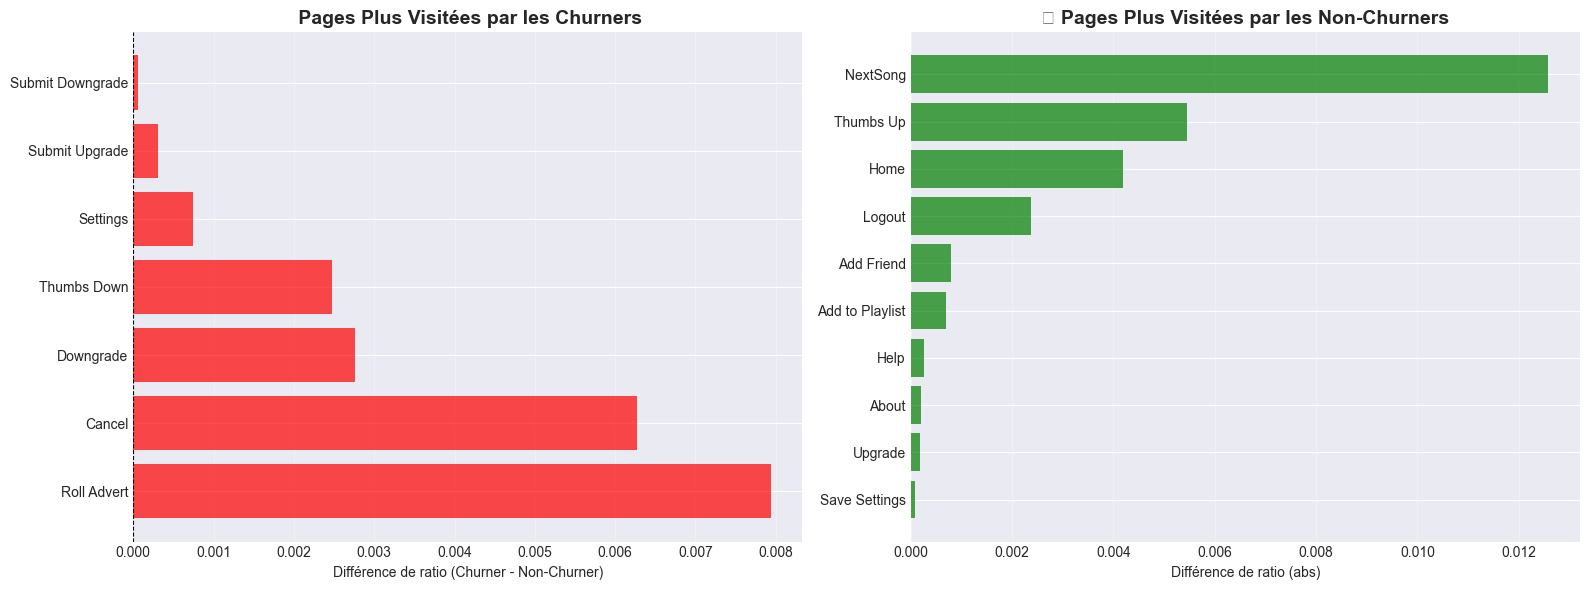

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_churner_pages = page_df[page_df['difference'] > 0].head(10)
axes[0].barh(top_churner_pages['page'], top_churner_pages['difference'], color='red', alpha=0.7)
axes[0].set_xlabel('Différence de ratio (Churner - Non-Churner)')
axes[0].set_title(' Pages Plus Visitées par les Churners', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

top_non_churner_pages = page_df[page_df['difference'] < 0].tail(10)
axes[1].barh(top_non_churner_pages['page'], abs(top_non_churner_pages['difference']), color='green', alpha=0.7)
axes[1].set_xlabel('Différence de ratio (abs)')
axes[1].set_title('🟢 Pages Plus Visitées par les Non-Churners', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
user_temporal = train.groupby('userId').agg({
    'time': ['min', 'max', 'count'],
    'page': lambda x: list(x)
}).reset_index()

user_temporal.columns = ['userId', 'time_min', 'time_max', 'total_events', 'pages']

user_temporal['duration_days'] = (user_temporal['time_max'] - user_temporal['time_min']).dt.days
user_temporal['events_per_day'] = user_temporal['total_events'] / (user_temporal['duration_days'] + 1)

user_temporal = user_temporal.merge(user_churn, on='userId')

temporal_df = user_temporal[['userId', 'is_churner', 'total_events', 'duration_days', 'events_per_day']].copy()

print(temporal_df.groupby('is_churner')[['total_events', 'duration_days', 'events_per_day']].mean())

            total_events  duration_days  events_per_day
is_churner                                             
0             913.287376      34.553097       26.460755
1             917.809881      19.293140       53.742171


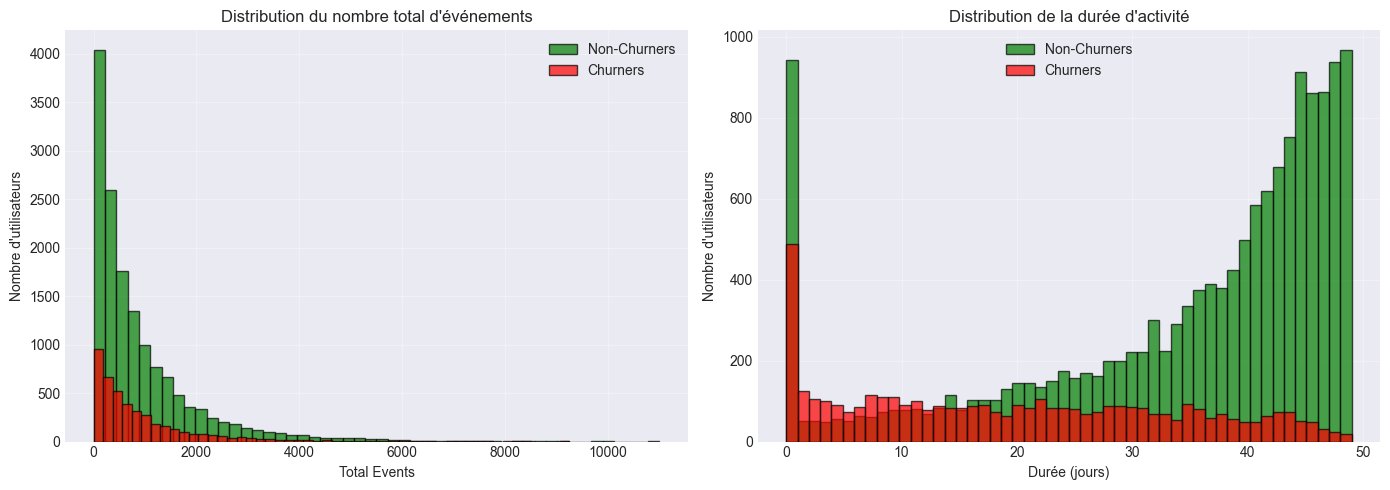

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

temporal_df[temporal_df['is_churner'] == 0]['total_events'].hist(bins=50, ax=axes[0], alpha=0.7, label='Non-Churners', color='green', edgecolor='black')
temporal_df[temporal_df['is_churner'] == 1]['total_events'].hist(bins=50, ax=axes[0], alpha=0.7, label='Churners', color='red', edgecolor='black')
axes[0].set_xlabel('Total Events')
axes[0].set_ylabel('Nombre d\'utilisateurs')
axes[0].set_title('Distribution du nombre total d\'événements')
axes[0].legend()
axes[0].grid(alpha=0.3)

temporal_df[temporal_df['is_churner'] == 0]['duration_days'].hist(bins=50, ax=axes[1], alpha=0.7, label='Non-Churners', color='green', edgecolor='black')
temporal_df[temporal_df['is_churner'] == 1]['duration_days'].hist(bins=50, ax=axes[1], alpha=0.7, label='Churners', color='red', edgecolor='black')
axes[1].set_xlabel('Durée (jours)')
axes[1].set_ylabel('Nombre d\'utilisateurs')
axes[1].set_title('Distribution de la durée d\'activité')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
engagement_df = pd.DataFrame({'userId': user_page_ratios['userId'], 
                                'is_churner': user_page_ratios['is_churner']})

page_cols = user_page_matrix.columns
engagement_df['thumbs_up_ratio'] = user_page_ratios.get('Thumbs Up', 0)
engagement_df['thumbs_down_ratio'] = user_page_ratios.get('Thumbs Down', 0)
engagement_df['add_playlist_ratio'] = user_page_ratios.get('Add to Playlist', 0)
engagement_df['add_friend_ratio'] = user_page_ratios.get('Add Friend', 0)
engagement_df['help_ratio'] = user_page_ratios.get('Help', 0)
engagement_df['error_ratio'] = user_page_ratios.get('Error', 0)
engagement_df['roll_advert_ratio'] = user_page_ratios.get('Roll Advert', 0) if 'Roll Advert' in page_cols else 0
engagement_df['cancel_ratio'] = user_page_ratios.get('Cancel', 0) if 'Cancel' in page_cols else 0
engagement_df['settings_ratio'] = user_page_ratios.get('Settings', 0) if 'Settings' in page_cols else 0

engagement_df['has_downgraded'] = (user_page_matrix.get('Downgrade', 0) > 0).astype(int)
engagement_df['has_upgraded'] = (user_page_matrix.get('Upgrade', 0) > 0).astype(int)

engagement_df['engagement_score'] = (
    (user_page_ratios.get('Thumbs Up', 0) - user_page_ratios.get('Thumbs Down', 0)) / 
    (user_page_ratios.get('Thumbs Up', 0) + user_page_ratios.get('Thumbs Down', 0) + 0.001)
)

engagement_df['positive_ratio'] = (
    user_page_ratios.get('Thumbs Up', 0) + 
    user_page_ratios.get('Add to Playlist', 0) + 
    user_page_ratios.get('Add Friend', 0)
)

engagement_df['negative_ratio'] = (
    user_page_ratios.get('Thumbs Down', 0) + 
    user_page_ratios.get('Help', 0) + 
    user_page_ratios.get('Error', 0) + 
    (user_page_ratios.get('Roll Advert', 0) if 'Roll Advert' in page_cols else 0)
)

print("Moyennes par Groupe:\n")
comparison = engagement_df.groupby('is_churner')[['thumbs_up_ratio', 'thumbs_down_ratio', 
                                                'add_playlist_ratio', 'help_ratio', 
                                                'error_ratio', 'roll_advert_ratio',
                                                'cancel_ratio', 'engagement_score',
                                                'positive_ratio', 'negative_ratio']].mean()
print(comparison)

Moyennes par Groupe:

            thumbs_up_ratio  thumbs_down_ratio  add_playlist_ratio  \
is_churner                                                           
0                  0.044063           0.009613            0.022413   
1                  0.038605           0.012088            0.021725   

            help_ratio  error_ratio  roll_advert_ratio  cancel_ratio  \
is_churner                                                             
0             0.005109     0.001019           0.031107      0.000000   
1             0.004840     0.001018           0.039042      0.006272   

            engagement_score  positive_ratio  negative_ratio  
is_churner                                                    
0                   0.611082        0.081719        0.046848  
1                   0.515060        0.074773        0.056988  


/var/folders/rq/gbrjppds5pzc_g5hjfc4wvfc0000gn/T/ipykernel_859/792983361.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Non-Churners', 'Churners'],
/var/folders/rq/gbrjppds5pzc_g5hjfc4wvfc0000gn/T/ipykernel_859/792983361.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Non-Churners', 'Churners'],
/var/folders/rq/gbrjppds5pzc_g5hjfc4wvfc0000gn/T/ipykernel_859/792983361.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Non-Churners', 'Churners'],
/var/folders/rq/gbrjppds5pzc_g5hjfc4wvfc0000gn

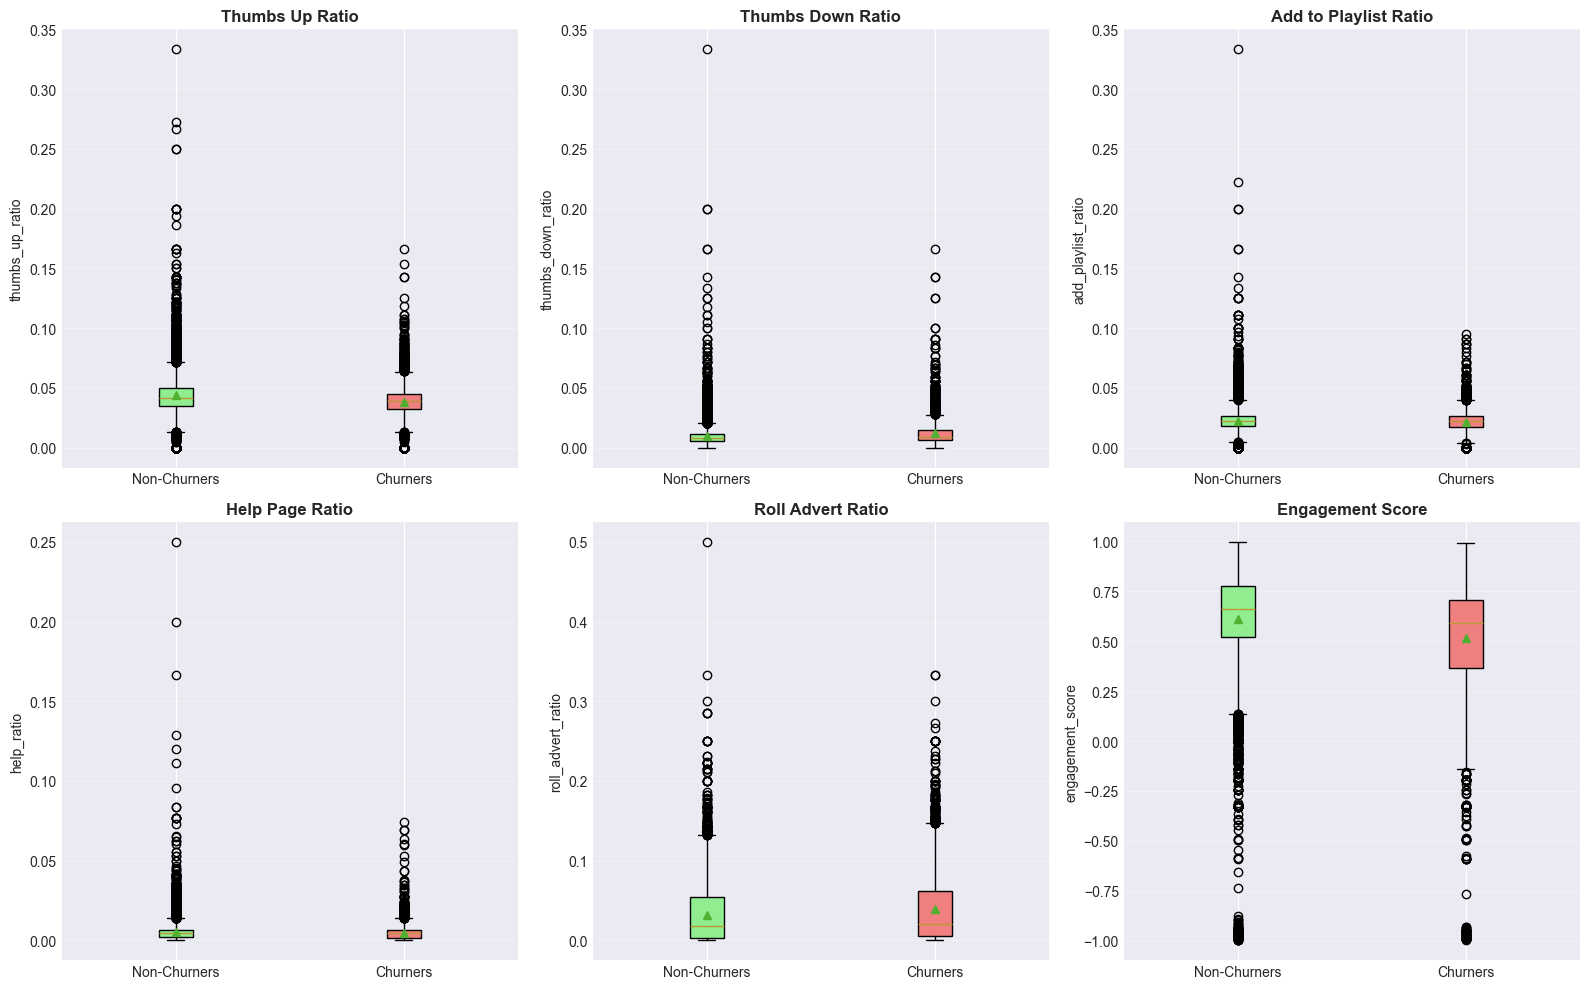

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics = [
    ('thumbs_up_ratio', 'Thumbs Up Ratio', 'green'),
    ('thumbs_down_ratio', 'Thumbs Down Ratio', 'red'),
    ('add_playlist_ratio', 'Add to Playlist Ratio', 'blue'),
    ('help_ratio', 'Help Page Ratio', 'orange'),
    ('roll_advert_ratio', 'Roll Advert Ratio', 'purple'),
    ('engagement_score', 'Engagement Score', 'cyan')
]

for idx, (metric, title, color) in enumerate(metrics):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]

    data_to_plot = [
        engagement_df[engagement_df['is_churner'] == 0][metric],
        engagement_df[engagement_df['is_churner'] == 1][metric]
    ]

    bp = ax.boxplot(data_to_plot, labels=['Non-Churners', 'Churners'],
                    patch_artist=True, showmeans=True)

    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')

    ax.set_ylabel(metric)
    ax.set_title(title, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
level_df = train.groupby('userId').agg({
    'level': lambda x: (x == 'paid').mean(),
    'gender': 'first'
}).reset_index()

level_df.columns = ['userId', 'paid_ratio', 'gender']
level_df = level_df.merge(user_churn, on='userId')

print("Paid Ratio par Groupe de Churn:")
print(level_df.groupby('is_churner')['paid_ratio'].describe())

Paid Ratio par Groupe de Churn:
              count      mean       std  min       25%       50%       75%  \
is_churner                                                                   
0           14869.0  0.530144  0.423771  0.0  0.000000  0.687914  0.946716   
1            4271.0  0.575142  0.400291  0.0  0.053024  0.724409  0.958842   

            max  
is_churner       
0           1.0  
1           1.0  


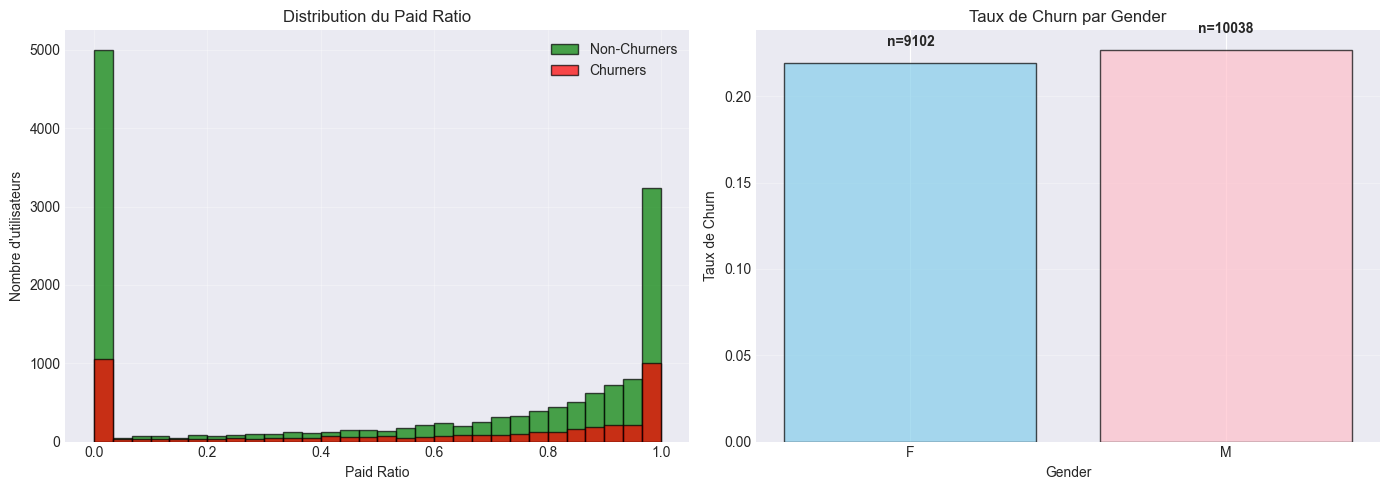

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(level_df[level_df['is_churner'] == 0]['paid_ratio'], bins=30, alpha=0.7,
             label='Non-Churners', color='green', edgecolor='black')
axes[0].hist(level_df[level_df['is_churner'] == 1]['paid_ratio'], bins=30, alpha=0.7,
             label='Churners', color='red', edgecolor='black')
axes[0].set_xlabel('Paid Ratio')
axes[0].set_ylabel('Nombre d\'utilisateurs')
axes[0].set_title('Distribution du Paid Ratio')
axes[0].legend()
axes[0].grid(alpha=0.3)

gender_churn = level_df.groupby('gender')['is_churner'].agg(['mean', 'count'])
axes[1].bar(gender_churn.index, gender_churn['mean'], color=['skyblue', 'pink'],
            edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Taux de Churn')
axes[1].set_xlabel('Gender')
axes[1].set_title('Taux de Churn par Gender')
axes[1].grid(axis='y', alpha=0.3)

for i, (idx, row) in enumerate(gender_churn.iterrows()):
    axes[1].text(i, row['mean'] + 0.01, f"n={int(row['count'])}",
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
columns_to_drop = [
    'firstName', 'lastName', 'status',
    'ts', 
    'auth',
    'method',
    'song',
    'location',
    'userAgent' 
]

train_clean = train.drop(columns=columns_to_drop)
test_clean = test.drop(columns=columns_to_drop)

print(f"Train shape après nettoyage: {train_clean.shape}")
print(f"Test shape après nettoyage: {test_clean.shape}")

Train shape après nettoyage: (17499636, 10)
Test shape après nettoyage: (4393179, 10)


In [16]:
def create_user_features(df, is_train=True):
    features = []
    
    for user_id, user_df in df.groupby('userId'):
        user_features = {'userId': user_id}
        
        user_features['gender'] = user_df['gender'].iloc[0]
        total = len(user_df)
        user_features['total_events'] = total
        user_features['num_sessions'] = user_df['sessionId'].nunique()
        
        time_min = user_df['time'].min()
        time_max = user_df['time'].max()
        user_features['days_since_registration'] = (time_max - user_df['registration'].iloc[0]).days
        user_features['activity_days'] = (time_max - time_min).days
        
        user_features['paid_ratio'] = (user_df['level'] == 'paid').mean()
        
        page_counts = user_df['page'].value_counts()
        
        thumbs_up = page_counts.get('Thumbs Up', 0)
        thumbs_down = page_counts.get('Thumbs Down', 0)
        user_features['thumbs_up'] = thumbs_up / total
        user_features['add_playlist'] = page_counts.get('Add to Playlist', 0) / total
        
        user_features['thumbs_down'] = thumbs_down / total
        user_features['help'] = page_counts.get('Help', 0) / total
        user_features['error'] = page_counts.get('Error', 0) / total
        
        user_features['downgrade'] = 1 if 'Downgrade' in page_counts else 0
        user_features['upgrade'] = 1 if 'Upgrade' in page_counts else 0
        
        mid_time = time_min + (time_max - time_min) / 2
        first_half = (user_df['time'] <= mid_time).sum()
        second_half = (user_df['time'] > mid_time).sum()
        user_features['activity_decreasing'] = 1 if second_half < first_half else 0
        
        last_7_days = user_df[user_df['time'] >= (time_max - pd.Timedelta(days=7))]
        user_features['events_last_7_days_ratio'] = len(last_7_days) / total
        
        last_3_days = user_df[user_df['time'] >= (time_max - pd.Timedelta(days=3))]
        user_features['events_last_3_days_ratio'] = len(last_3_days) / total
        
        user_features['engagement_ratio'] = (thumbs_up - thumbs_down) / (thumbs_up + thumbs_down + 1)
        
        daily_events = user_df.groupby(user_df['time'].dt.date).size()
        if len(daily_events) > 1:
            user_features['activity_regularity'] = 1 / (daily_events.std() + 1)
        else:
            user_features['activity_regularity'] = 0
        
        active_days = user_df['time'].dt.date.nunique()
        total_days = (time_max - time_min).days + 1
        user_features['inactive_days_ratio'] = (total_days - active_days) / total_days if total_days > 0 else 0
        
        session_lengths = user_df.groupby('sessionId').size()
        user_features['avg_session_length'] = session_lengths.mean()
        
        days_7_to_14 = user_df[(user_df['time'] >= (time_max - pd.Timedelta(days=14))) & 
                                (user_df['time'] < (time_max - pd.Timedelta(days=7)))]
        if len(days_7_to_14) > 0:
            user_features['activity_trend_7days'] = len(last_7_days) / len(days_7_to_14)
        else:
            user_features['activity_trend_7days'] = 1.0
        
        if len(last_7_days) > 0:
            page_counts_recent = last_7_days['page'].value_counts()
            negative_pages_recent = (
                page_counts_recent.get('Help', 0) +
                page_counts_recent.get('Error', 0) +
                page_counts_recent.get('Thumbs Down', 0) +
                page_counts_recent.get('Cancel', 0)
            )
            user_features['negative_pages_last_7days_ratio'] = negative_pages_recent / len(last_7_days)
        else:
            user_features['negative_pages_last_7days_ratio'] = 0
        
        if len(last_7_days) > 0:
            recent_page_counts = last_7_days['page'].value_counts()
            user_features['thumbs_up_last_7days_ratio'] = recent_page_counts.get('Thumbs Up', 0) / len(last_7_days)
        else:
            user_features['thumbs_up_last_7days_ratio'] = 0
        
        if len(last_7_days) > 0:
            user_features['paid_ratio_last_7days'] = (last_7_days['level'] == 'paid').mean()
        else:
            user_features['paid_ratio_last_7days'] = user_features['paid_ratio']
        
        user_features['visited_cancel'] = 1 if 'Cancel' in page_counts else 0
        user_features['visited_settings'] = 1 if 'Settings' in page_counts else 0
        
        artists = user_df[user_df['artist'].notna()]['artist'].nunique()
        user_features['unique_artists'] = artists
        
        if is_train:
            user_features['churn'] = 1 if (user_df['page'] == 'Cancellation Confirmation').any() else 0
        
        features.append(user_features)
    
    return pd.DataFrame(features)


In [17]:
train_features = create_user_features(train_clean, is_train=True)
test_features = create_user_features(test_clean, is_train=False)

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (19140, 29)
Test features shape: (2904, 28)


In [18]:
train_features_encoded = train_features.copy()
test_features_encoded = test_features.copy()

features_to_drop = ['visited_cancel', 'visited_settings', 'downgrade', 'upgrade']
print(f" Retrait des features problématiques: {features_to_drop}")

for feat in features_to_drop:
    if feat in train_features_encoded.columns:
        train_features_encoded = train_features_encoded.drop(columns=[feat])
    if feat in test_features_encoded.columns:
        test_features_encoded = test_features_encoded.drop(columns=[feat])

train_features_encoded['gender'] = train_features_encoded['gender'].fillna('Unknown')
test_features_encoded['gender'] = test_features_encoded['gender'].fillna('Unknown')

all_genders = pd.concat([train_features_encoded['gender'], test_features_encoded['gender']]).unique()
le = LabelEncoder()
le.fit(all_genders)

train_features_encoded['gender'] = le.transform(train_features_encoded['gender'])
test_features_encoded['gender'] = le.transform(test_features_encoded['gender'])

print(f" Genre encodé: {dict(zip(le.classes_, le.transform(le.classes_)))}")

X_full = train_features_encoded.drop(columns=['userId', 'churn'])
y_full = train_features_encoded['churn']

from sklearn.model_selection import train_test_split
X_train_temporal, X_val_temporal, y_train_temporal, y_val_temporal = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print(f"   Train : {len(X_train_temporal)} utilisateurs")
print(f"   Val   : {len(X_val_temporal)} utilisateurs")

print(f"\n   Churners dans train : {y_train_temporal.sum()} ({y_train_temporal.mean()*100:.2f}%)")
print(f"   Churners dans val   : {y_val_temporal.sum()} ({y_val_temporal.mean()*100:.2f}%)")


 Retrait des features problématiques: ['visited_cancel', 'visited_settings', 'downgrade', 'upgrade']
 Genre encodé: {'F': np.int64(0), 'M': np.int64(1), 'Unknown': np.int64(2)}
   Train : 15312 utilisateurs
   Val   : 3828 utilisateurs

   Churners dans train : 3417 (22.32%)
   Churners dans val   : 854 (22.31%)


In [19]:

model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train_temporal == 0).sum() / (y_train_temporal == 1).sum(),
    random_state=42,
    eval_metric='auc'
)


model.fit(
    X_train_temporal, y_train_temporal,
    eval_set=[(X_val_temporal, y_val_temporal)],
    verbose=50
)


[0]	validation_0-auc:0.90262
[50]	validation_0-auc:0.93122
[50]	validation_0-auc:0.93122
[100]	validation_0-auc:0.93452
[100]	validation_0-auc:0.93452
[150]	validation_0-auc:0.93503
[150]	validation_0-auc:0.93503
[199]	validation_0-auc:0.93544
[199]	validation_0-auc:0.93544


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'



Top 10 features les plus importantes:
                            feature  importance
4                     activity_days    0.242780
19  negative_pages_last_7days_ratio    0.146768
16              inactive_days_ratio    0.115715
2                      num_sessions    0.070297
21            paid_ratio_last_7days    0.037285
6                         thumbs_up    0.035084
8                       thumbs_down    0.030389
9                              help    0.028228
3           days_since_registration    0.028058
5                        paid_ratio    0.024945


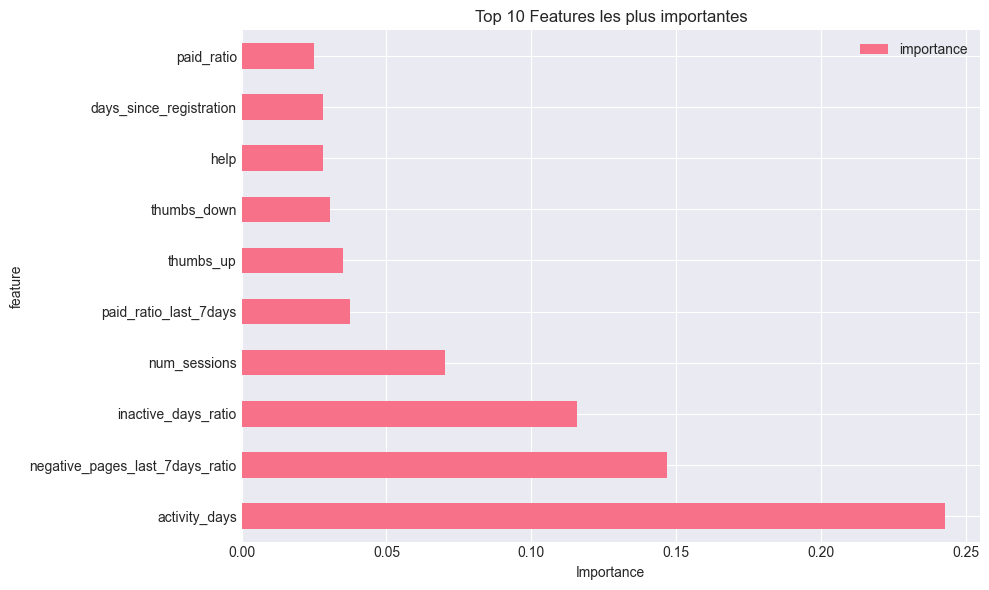

In [20]:
import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_train_temporal.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features les plus importantes:")
print(feature_importance.head(10))

fig, ax = plt.subplots(figsize=(10, 6))
feature_importance.head(10).plot(x='feature', y='importance', kind='barh', ax=ax)
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features les plus importantes')
plt.tight_layout()
plt.show()


In [21]:
X_test_final = test_features_encoded.drop(columns=['userId'])

test_predictions = model.predict(X_test_final)


submission = pd.DataFrame({
    'id': test_features['userId'],
    'churn': test_predictions.astype(int)
})

print(submission.head(10))

print(f"   • Nombre de prédictions : {len(submission)}")
print(f"   • Churners prédits : {test_predictions.sum()} utilisateurs")
print(f"   • Taux de churn prédit : {test_predictions.mean() * 100:.2f}%")

submission.to_csv('submission_1.csv', index=False)
print("Fichier 'submission_1.csv' créé avec succès !")

        id  churn
0  1000655      0
1  1000963      0
2  1001129      0
3  1001963      0
4  1002283      0
5  1002397      0
6  1002533      0
7  1002712      0
8  1002879      0
9  1003703      0
   • Nombre de prédictions : 2904
   • Churners prédits : 261 utilisateurs
   • Taux de churn prédit : 8.99%
Fichier 'submission_1.csv' créé avec succès !
